# Demo for Localization Overlap in MMA Cases

Authors: Amanda Beck, Zsuzsa Marka

In [1]:
# imports:
from astropy.coordinates import SkyCoord, Galactic, ICRS, FK5
from astropy.table import Column, Table, join
from ligo.skymap.io import read_sky_map
from matplotlib import pyplot as plt
from astropy_healpix import HEALPix
import astropy.coordinates as coord
from astropy import units as u
from astropy.io import fits, ascii
import ligo.skymap.plot
import ligo.skymap.moc
import healpy as hp
import numpy as np
import scipy
import math
%matplotlib inline

## GW170817 Binary Neutron Star Merger and Neutrino Overlap:

### BNS Data:

In [2]:
# opening BNS LIGO data:
GW170817 = '../data/GW170817_skymap.fits' 
bns_data = Table.read(GW170817, format='fits')

# adding an index row to prevent pixel scrambling:
index = Column(np.arange(len(bns_data)), name='INDEX')
bns_data.add_column(index, index=0)

bns_data

INDEX,PROB,DISTMU,DISTSIGMA,DISTNORM
,1 / pix,Mpc,Mpc,1 / Mpc2
int64,float64,float64,float64,float64
0,0.0,0.588122259234962,0.12664444738884278,2.7629911260157716
1,0.0,0.588122259234962,0.12664444738884278,2.7629911260157716
2,0.0,0.588122259234962,0.12664444738884278,2.7629911260157716
3,0.0,0.588122259234962,0.12664444738884278,2.7629911260157716
4,0.0,0.588122259234962,0.12664444738884278,2.7629911260157716
5,0.0,0.588122259234962,0.12664444738884278,2.7629911260157716
6,0.0,0.588122259234962,0.12664444738884278,2.7629911260157716
7,0.0,0.588122259234962,0.12664444738884278,2.7629911260157716


In [3]:
fits.getheader('../data/GW170817_skymap.fits', 1)

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   32 / length of dimension 1                          
NAXIS2  =             12582912 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    4 / number of table fields                         
TTYPE1  = 'PROB    '                                                            
TFORM1  = 'D       '                                                            
TUNIT1  = 'pix-1   '                                                            
TTYPE2  = 'DISTMU  '                                                            
TFORM2  = 'D       '        

### Isolating 90% Probability Area:

In [4]:
# isolating 90% probability area:
def isolate_90_area(data, order=None):
    ''' 
    Isolates the 90% highest probability area.

    Parameters:
    -----------
    data: Table or DataFrame
        LIGO data containing pixel probability column.
        
    Returns:
    -----------
    ninety_area: Table or DataFrame
        Isolated 90% probability area pixels of the LIGO data.  
    '''
    # ordering table by probability:
    data = np.sort(bns_data, order=order)
    # adding from top to bottom till 90% prob area:
    data = Table(bns_data)[::-1]
    s = 0
    for i in range(len(bns_data['PROB'])):
        ninety_area = bns_data[:i]
        s += bns_data['PROB'][i]
        if (s >= 0.9):
            break
    
    return ninety_area

In [5]:
bns_ninety_area = isolate_90_area(bns_data, order='PROB')
bns_ninety_area

INDEX,PROB,DISTMU,DISTSIGMA,DISTNORM
int64,float64,float64,float64,float64
6376622,0.00048614700519965644,35.17109105811737,7.481757282146153,0.0007734057725451106
6376620,0.00048540165639012124,35.39640936254927,7.4403039693594675,0.00076437176672537
6376965,0.0004849726578483823,35.56625470072729,7.357269518332313,0.0007580996011745014
6376623,0.0004838749862290262,35.785849123662715,7.317852152527875,0.0007495252006670972
6376964,0.00048347454237884465,34.96216240876593,7.525045955287046,0.0007818735994090918
6376611,0.00048328093520594604,35.03165136030263,7.565787498206285,0.0007785386603684383
6376617,0.0004830104634942047,34.826042919615375,7.609347112169375,0.0007869334930040232
6376967,0.00048264988532099277,35.34956614269714,7.397416748617443,0.0007666867859909103
6376614,0.00048154901649010134,35.63057255596844,7.399143308692568,0.0007551244522832314


### Finding Highest Probability Pixel:

In [6]:
# find highest probability pixel (my own way):
bns_highest_prob = bns_ninety_area[bns_ninety_area['PROB'] == np.amax(bns_ninety_area['PROB'])]
bns_highest_prob
# want RA and DEC.
# add ra dec converter here.

INDEX,PROB,DISTMU,DISTSIGMA,DISTNORM
int64,float64,float64,float64,float64
6376622,0.00048614700519965644,35.17109105811737,7.481757282146153,0.0007734057725451106


## Fermi Sub-threshold GCN (Gamma-ray Coordinates Network) Data:

In [7]:
# opening BNS LIGO data:
F170817 = '../data/F170817_13.fits'
data = Table.read(F170817)

data

PROBABILITY [1024],SIGNIFICANCE [1024]
float32,float32
5.158274e-05 .. 8.2165316e-05,0.26613468 .. 0.42392164
5.7483585e-06 .. 3.0052884e-06,0.029657934 .. 0.015505408
0.000106213774 .. 0.00013513463,0.54799664 .. 0.69721013
8.1101374e-05 .. 2.702895e-05,0.41843238 .. 0.13945247
3.065457e-07 .. 4.7087744e-07,0.001581584 .. 0.0024294332
5.3288534e-08 .. 5.9065615e-09,0.0002749355 .. 3.0474162e-05
3.1502657e-06 .. 7.783097e-07,0.0162534 .. 0.004015591
4.5463025e-07 .. 5.251986e-09,0.0023456078 .. 2.7096963e-05
8.548238e-05 .. 0.000115458446,0.4410356 .. 0.59569335


In [8]:
fits.getheader('../data/F170817_13.fits', 1)

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 8192 / length of dimension 1                          
NAXIS2  =                  192 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    2 / number of table fields                         
TTYPE1  = 'PROBABILITY'        / Differential probability per pixel             
TFORM1  = '1024E   '                                                            
TTYPE2  = 'SIGNIFICANCE'       / Integrated probability                         
TFORM2  = '1024E   '                                                            
PIXTYPE = 'HEALPIX '        

In [9]:
data['PROBABILITY'].shape

(192, 1024)

In [10]:
gbm_prob = np.concatenate((data['PROBABILITY']))
gbm_prob

array([5.1582741e-05, 4.9343795e-05, 5.6032834e-05, ..., 3.5819894e-09,
       3.1977319e-09, 3.5312013e-09], dtype=float32)

In [11]:
gbm_data = Table()
gbm_data['PROB'] = gbm_prob
gbm_data['INDEX'] = np.arange(len(gbm_prob))

In [12]:
gbm_data

PROB,INDEX
float32,int64
5.158274e-05,0
4.9343795e-05,1
5.6032834e-05,2
5.3568343e-05,3
4.7041394e-05,4
4.4675562e-05,5
5.126602e-05,6
4.958198e-05,7
6.0772105e-05,8


In [13]:
gbm_ninety_area = isolate_90_area(gbm_data, order='PROB')

In [14]:
gbm_ninety_area

PROB,INDEX
float32,int64
0.00019308114,8860
0.00019302715,8857
0.00019271714,8862
0.0001926637,8859
0.00019265607,8863
0.00019263176,8854
0.00019255606,8861
0.00019255471,8905
0.00019249636,8858


## IceCube Neutrino Data:

In [19]:
IceCube = '../data/icecube_10year_ps/events/IC86_VI_exp.csv'
n_data = ascii.read(IceCube, data_start=1, delimiter=' ', format='csv')

n_data

MJD[days],log10(E/GeV),AngErr[deg],RA[deg],Dec[deg],Azimuth[deg],Zenith[deg]
float64,float64,float64,float64,float64,float64,float64
57528.87234241,2.93,0.62,296.414,39.089,346.423,129.134
57528.87408644,3.68,0.72,352.429,-3.112,290.977,86.981
57528.87733405,2.97,1.59,262.432,17.035,22.168,107.028
57528.87801159,2.98,0.23,51.371,22.266,233.424,112.318
57528.87907391,3.05,0.9,255.736,59.652,29.617,149.633
57528.87960696,3.02,0.29,244.072,-1.872,41.317,88.091
57528.88107602,3.02,2.78,85.551,21.63,200.344,111.631
57528.88298032,2.86,0.3,275.852,43.615,10.846,133.629
57528.8869736,4.61,0.55,142.68,-79.481,145.664,10.434


In [20]:
n_data[86958] # neutrino closest in timing to GW170817
# convert from MJD to UTC time
# write to print all which is within +- 500 secs (~3-5)

MJD[days],log10(E/GeV),AngErr[deg],RA[deg],Dec[deg],Azimuth[deg],Zenith[deg]
float64,float64,float64,float64,float64,float64,float64
57782.34200181,2.92,0.72,311.788,3.686,29.897,93.752


### Plotting:

In [21]:
DPI = 200
WIDTH = 6  # [inches]
HEIGHT = 4  # [inches]
LEFT_SHIFT_COEFF = 1/20.  # quadratic curve dec labels away from meridian
LEFT_SHIFT_BASE = -20  # baseline shift from leftmost meridian [deg]
XMARGIN = 0.4  # additional margin in x (make sure text fits) [inches]
TOPMARGIN = -0.0  # additional margin at top [inches]
BOTTOMMARGIN = -0.0  # additional margin at bottom [inches]
DEC_X_OFFSET = -0.37  # [inches]
DEC_Y_OFFSET = -0.02  # [inches]
RA_X_OFFSET = 0  # [inches]
RA_Y_OFFSET = 0.06  # [inches]
N_X_OFFSET = 0.08  # [inches]
N_Y_OFFSET = 0.08  # [inches]
CENTRAL_LON = 180  # longitude to place at center of skymap [deg]
CENTRAL_LAT = 0  # latitude to place at center of skymap [deg]
PSI = 0  # additional rotation of skymap about center
DELTA_PARALLEL = 15  # space between parallels in the graticule [deg]
DELTA_MERIDIAN = 30  # space between meridians in the graticule [deg]
GRATICULE_COLOR = "#B0B0B0"
GRATICULE_LABEL_COLOR = (0.2, 0.2, 0.2)
MERIDIAN_FONT_SIZE = 11
FONT_SIZE = 14  # matplotlib font size
UNCERTAINTY_ALPHA = 0.4  # opacity in [0,1] for scatterplot uncertainty discs
DEFAULT_PLOT_EXTENSION = 'pdf'  # file type to save plots as

def plot_mollview(skymap,
                nest,
                title=None,
                unit="Prob. Density",
                central_longitude=CENTRAL_LON,
                central_latitude=CENTRAL_LAT,
                rotation_about_center=PSI,
                dpi=DPI,
                graticule=15,
                cbar=None,
                cmap=None,
                alpha=None,
                **kwargs):
    
    from matplotlib.transforms import ScaledTranslation
    kwargs['rot'] = kwargs.get('rot', (180, 0, 0))
    
    hp.mollview(skymap, 
                nest=nest, 
                cmap=cmap, 
                title=title, 
                unit=unit, 
                rot=(central_longitude, central_latitude, rotation_about_center)
               )
    hp.graticule(graticule)
    
    # size the figure
    fig = plt.gcf()
    fig.set_size_inches(WIDTH, HEIGHT)
    fig.set_dpi(dpi)
    if title is not None:
        plt.title(
            title
            )
        
    # add extra margin so that the declination labels fit
    x_1, x_2, y_1, y_2 = plt.axis()
    plt.axis((x_1-XMARGIN, x_2+XMARGIN, y_1-TOPMARGIN, y_2+BOTTOMMARGIN))
    
    # Make a matplotlib translation to offset text labels by a bit so that
    # they don't cover up the scatter plot markers they are labeling. See:
    # https://matplotlib.org/users/transforms_tutorial.html
    transdata = plt.gca().transData
    dectrans = transdata + ScaledTranslation(DEC_X_OFFSET, DEC_Y_OFFSET, fig.dpi_scale_trans)
    ratrans = transdata + ScaledTranslation(RA_X_OFFSET, RA_Y_OFFSET, fig.dpi_scale_trans)
    
    # add a graticule
    hp.graticule(
        DELTA_PARALLEL,
        DELTA_MERIDIAN,
        color=GRATICULE_COLOR,
    )
    
    # label declinations
    for dec in np.arange(DELTA_PARALLEL-90, 90, DELTA_PARALLEL):
        hp.projtext(
            # curve dec labels away from leftmost meridian
            LEFT_SHIFT_BASE+abs(dec*LEFT_SHIFT_COEFF)**2,
            dec,
            # label dec, right-pad to avoid hitting plot
            str(dec) + '$\\degree$',
            lonlat=True,
            color=GRATICULE_LABEL_COLOR,
            transform=dectrans,
            horizontalalignment='right',
            verticalalignment='center'
        )
    # label right ascensions
    for right_ascension in np.arange(DELTA_MERIDIAN, 360, DELTA_MERIDIAN):
        hp.projtext(
            right_ascension,
            0,
            str(right_ascension) + '$\\degree$',
            lonlat=True,
            color=GRATICULE_LABEL_COLOR,
            transform=ratrans,
            horizontalalignment='center',
            verticalalignment='bottom',
            fontsize=MERIDIAN_FONT_SIZE
        )
    return fig

0.0 180.0 -180.0 180.0
The interval between parallels is 15 deg -0.00'.
The interval between meridians is 15 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 15 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


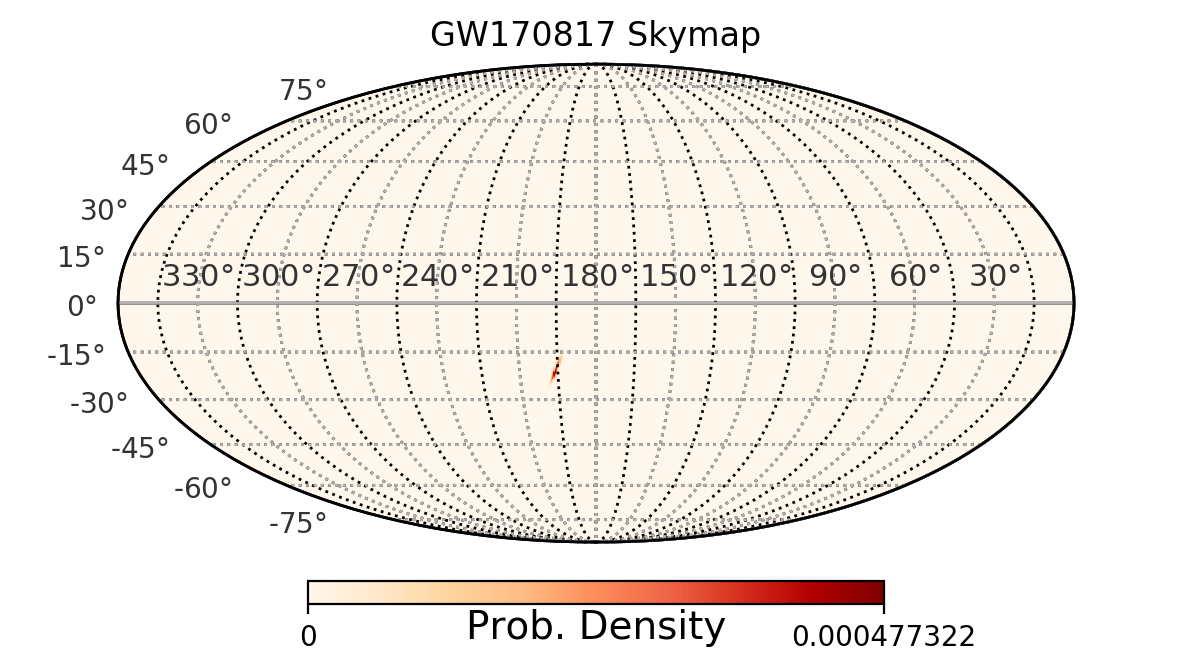

In [55]:
plot_mollview(bns_data['PROB'], nest=True, cmap='OrRd', title='GW170817 Skymap')
plt.savefig('../plots/BNS_Skymap.pdf', overwrite=True)
# zoom into area of event.

0.0 180.0 -180.0 180.0
The interval between parallels is 15 deg -0.00'.
The interval between meridians is 15 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 15 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


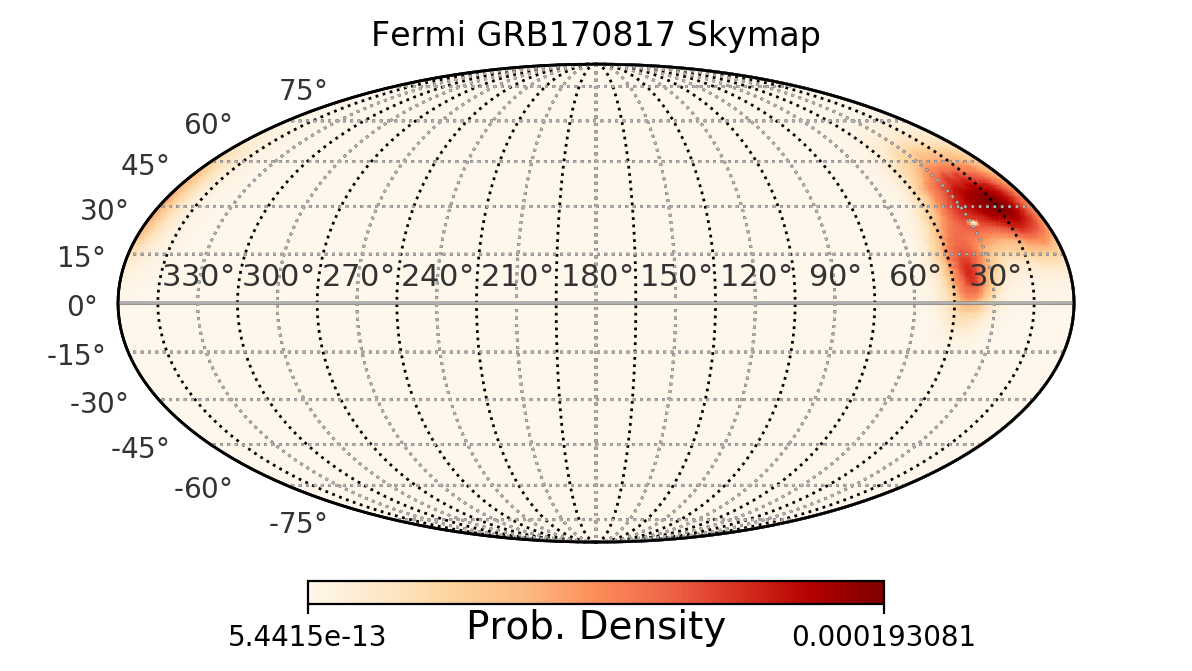

In [56]:
# plots correctly!
plot_mollview(gbm_data['PROB'], nest=True, cmap='OrRd', title='Fermi GRB170817 Skymap')
plt.savefig('../plots/gbm_Skymap.pdf', overwrite=True)

0.0 180.0 -180.0 180.0
The interval between parallels is 15 deg -0.00'.
The interval between meridians is 15 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 15 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


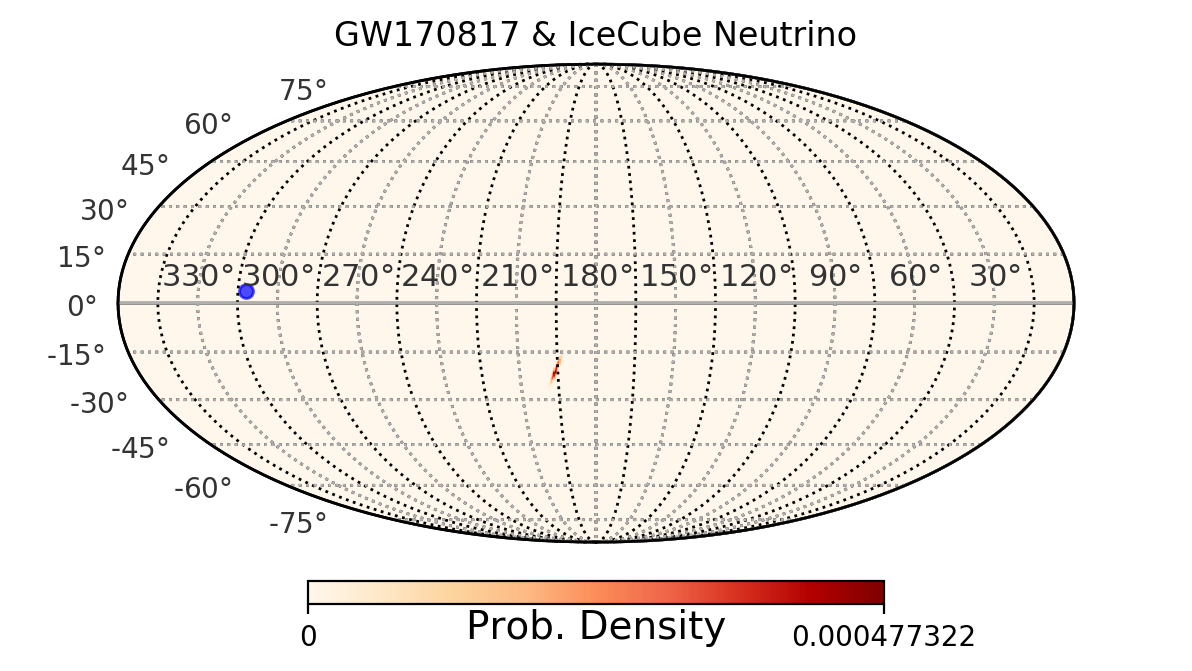

In [57]:
plot_mollview(bns_data['PROB'], nest=True, cmap='OrRd', title='GW170817 & IceCube Neutrino')
hp.projscatter(n_data[86958]['RA[deg]'], n_data[86958]['Dec[deg]'], marker='.', s=100, c='b', lonlat=True, alpha=0.7)
plt.savefig('../plots/gbm_neutrino_Skymap.pdf', overwrite=True)

## BBH and AllWISE AGN Overlap:

### BBH Data:

In [25]:
# opening BBH LIGO data:
S190521g = '../data/S190521g/bayestar2.fits' 
bbh_data = Table.read(S190521g)

bbh_data
# multiorder maps: LIGO DCC gwtc2

PROB,DISTMU,DISTSIGMA,DISTNORM
1 / pix,Mpc,Mpc,1 / Mpc2
float64,float64,float64,float64
3.420666741585511e-21,-73.1221838420601,404.8957816151533,1.642233920921469e-05
3.420666741585511e-21,-73.1221838420601,404.8957816151533,1.642233920921469e-05
3.420666741585511e-21,-73.1221838420601,404.8957816151533,1.642233920921469e-05
3.420666741585511e-21,-73.1221838420601,404.8957816151533,1.642233920921469e-05
3.420666741585511e-21,-73.1221838420601,404.8957816151533,1.642233920921469e-05
3.420666741585511e-21,-73.1221838420601,404.8957816151533,1.642233920921469e-05
3.420666741585511e-21,-73.1221838420601,404.8957816151533,1.642233920921469e-05
3.420666741585511e-21,-73.1221838420601,404.8957816151533,1.642233920921469e-05


In [26]:
# adding an index row to prevent pixel scrambling:
index = Column(np.arange(len(bbh_data)), name='INDEX')
bbh_data.add_column(index, index=0)

bbh_data

INDEX,PROB,DISTMU,DISTSIGMA,DISTNORM
,1 / pix,Mpc,Mpc,1 / Mpc2
int64,float64,float64,float64,float64
0,3.420666741585511e-21,-73.1221838420601,404.8957816151533,1.642233920921469e-05
1,3.420666741585511e-21,-73.1221838420601,404.8957816151533,1.642233920921469e-05
2,3.420666741585511e-21,-73.1221838420601,404.8957816151533,1.642233920921469e-05
3,3.420666741585511e-21,-73.1221838420601,404.8957816151533,1.642233920921469e-05
4,3.420666741585511e-21,-73.1221838420601,404.8957816151533,1.642233920921469e-05
5,3.420666741585511e-21,-73.1221838420601,404.8957816151533,1.642233920921469e-05
6,3.420666741585511e-21,-73.1221838420601,404.8957816151533,1.642233920921469e-05
7,3.420666741585511e-21,-73.1221838420601,404.8957816151533,1.642233920921469e-05


In [27]:
# getting nside value:
nside = int((len(bbh_data))/12)**(1/2)

In [51]:
bbh_ninety_area = isolate_90_area(bbh_data, order='PROB')
bbh_ninety_area

INDEX,PROB,DISTMU,DISTSIGMA,DISTNORM
int64,float64,float64,float64,float64
2140788,7.300594766653513e-05,578.6989651459575,134.65056071447785,2.8326746010215228e-06
2140790,7.299722728689103e-05,578.9672656632431,134.81122399518873,2.829837776746133e-06
2140789,7.29389530802557e-05,579.0822411319475,134.74802297664758,2.8289082668104363e-06
2140767,7.293684502413901e-05,578.8067055490524,134.5902546341876,2.831804472408014e-06
2140766,7.292514235949446e-05,578.4119804743116,134.50183436497926,2.8356635224898187e-06
2140787,7.292154195353686e-05,578.5848541112995,134.71609372018705,2.83359290283521e-06
2140793,7.290355613934275e-05,578.8463755128832,134.87939175200307,2.830811756595052e-06
2140796,7.28998063988666e-05,579.216459557833,134.98399802689323,2.827155840113906e-06
2140791,7.285160752936588e-05,579.3386406316629,134.91793374827972,2.826167292646987e-06


### AllWISE Data:

In [39]:
# opening BBH LIGO data:
cat = '../data/allwise.fits' 
allwise = Table.read(cat, format='fits')

allwise

NAME,RA,DEC,LII,BII,W1W2_COLOR,W2W3_COLOR,W1_MAG,GMAG,REDSHIFT,REDSHIFT_FLAG,LQAC2_NAME,DR12Q_NAME,MILLIQUAS_NAME
,DEGREE,DEGREE,DEGREE,DEGREE,MAG,MAG,MAG,MAG,,,,,
bytes25,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes13,bytes17,bytes24,bytes26
WISEA J184245.06-894911.0,280.68778,-89.81973,303.13432,-27.12127,0.95,3.48,15.15,0.00,0.00000,,,,
WISEA J043431.62-894617.9,68.63175,-89.77165,302.71954,-27.25653,1.32,3.07,15.12,0.00,0.00000,,,,
WISEA J220915.15-894514.2,332.31317,-89.75395,303.11194,-27.31510,0.95,3.57,16.08,0.00,0.00000,,,,
WISEA J094017.96-894442.8,145.07485,-89.74523,302.72023,-26.95691,0.96,3.16,14.27,0.00,0.00000,,,,
WISEA J233728.16-894436.2,354.36737,-89.74341,303.02356,-27.37156,1.04,3.00,15.21,0.00,0.00000,,,,
WISEA J024222.81-894245.1,40.59507,-89.71254,302.78126,-27.38260,1.19,3.13,15.69,0.00,0.00000,,,,
WISEA J004712.26-894157.4,11.80109,-89.69929,302.93818,-27.42891,1.24,3.19,13.66,0.00,0.00000,,,,
WISEA J051926.00-894114.2,79.85834,-89.68730,302.60814,-27.25007,1.56,3.09,15.09,0.00,0.00000,,,,


In [40]:
allwise['RA'].name = 'RAJ2000'
allwise['DEC'].name = 'DEJ2000'
allwise

NAME,RAJ2000,DEJ2000,LII,BII,W1W2_COLOR,W2W3_COLOR,W1_MAG,GMAG,REDSHIFT,REDSHIFT_FLAG,LQAC2_NAME,DR12Q_NAME,MILLIQUAS_NAME
,DEGREE,DEGREE,DEGREE,DEGREE,MAG,MAG,MAG,MAG,,,,,
bytes25,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes13,bytes17,bytes24,bytes26
WISEA J184245.06-894911.0,280.68778,-89.81973,303.13432,-27.12127,0.95,3.48,15.15,0.00,0.00000,,,,
WISEA J043431.62-894617.9,68.63175,-89.77165,302.71954,-27.25653,1.32,3.07,15.12,0.00,0.00000,,,,
WISEA J220915.15-894514.2,332.31317,-89.75395,303.11194,-27.31510,0.95,3.57,16.08,0.00,0.00000,,,,
WISEA J094017.96-894442.8,145.07485,-89.74523,302.72023,-26.95691,0.96,3.16,14.27,0.00,0.00000,,,,
WISEA J233728.16-894436.2,354.36737,-89.74341,303.02356,-27.37156,1.04,3.00,15.21,0.00,0.00000,,,,
WISEA J024222.81-894245.1,40.59507,-89.71254,302.78126,-27.38260,1.19,3.13,15.69,0.00,0.00000,,,,
WISEA J004712.26-894157.4,11.80109,-89.69929,302.93818,-27.42891,1.24,3.19,13.66,0.00,0.00000,,,,
WISEA J051926.00-894114.2,79.85834,-89.68730,302.60814,-27.25007,1.56,3.09,15.09,0.00,0.00000,,,,


In [41]:
def convert_RaDec_Index_manual(data, n_side):
    ''' 
    Manually converting RA and DEC to healpix nested pixel index (marginally faster than using astropy's methods).
    Adds pixel index, theta, and phi columns to data set.

    Parameters:
    -----------
    data: Table or DataFrame
        Must have Ra and Dec columns named as RAJ2000 and DEJ2000.
    n_side: float or int
        nside value corresponding to LIGO skymap to be crossmatched with the AGN data.
    '''
    n_side_array = np.full(len(data['RAJ2000']), int(n_side))
    theta = 0.5 * np.pi - np.deg2rad(data['DEJ2000'])
    phi = np.deg2rad(data['RAJ2000'])
    ipix = hp.ang2pix(n_side_array, theta, phi, nest=True)
    data.add_columns([np.array(ipix), theta, phi],
                     names=['INDEX', 'THETA', 'PHI'])

In [42]:
convert_RaDec_Index_manual(allwise, nside)
allwise

NAME,RAJ2000,DEJ2000,LII,BII,W1W2_COLOR,W2W3_COLOR,W1_MAG,GMAG,REDSHIFT,REDSHIFT_FLAG,LQAC2_NAME,DR12Q_NAME,MILLIQUAS_NAME,INDEX,THETA,PHI
,DEGREE,DEGREE,DEGREE,DEGREE,MAG,MAG,MAG,MAG,,,,,,,DEGREE,DEGREE
bytes25,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes13,bytes17,bytes24,bytes26,int64,float64,float64
WISEA J184245.06-894911.0,280.68778,-89.81973,303.13432,-27.12127,0.95,3.48,15.15,0.00,0.00000,,,,,2883586,3.13845,4.89893
WISEA J043431.62-894617.9,68.63175,-89.77165,302.71954,-27.25653,1.32,3.07,15.12,0.00,0.00000,,,,,2097153,3.13761,1.19785
WISEA J220915.15-894514.2,332.31317,-89.75395,303.11194,-27.31510,0.95,3.57,16.08,0.00,0.00000,,,,,2883585,3.13730,5.79996
WISEA J094017.96-894442.8,145.07485,-89.74523,302.72023,-26.95691,0.96,3.16,14.27,0.00,0.00000,,,,,2359299,3.13715,2.53203
WISEA J233728.16-894436.2,354.36737,-89.74341,303.02356,-27.37156,1.04,3.00,15.21,0.00,0.00000,,,,,2883588,3.13711,6.18488
WISEA J024222.81-894245.1,40.59507,-89.71254,302.78126,-27.38260,1.19,3.13,15.69,0.00,0.00000,,,,,2097155,3.13658,0.70852
WISEA J004712.26-894157.4,11.80109,-89.69929,302.93818,-27.42891,1.24,3.19,13.66,0.00,0.00000,,,,,2097160,3.13634,0.20597
WISEA J051926.00-894114.2,79.85834,-89.68730,302.60814,-27.25007,1.56,3.09,15.09,0.00,0.00000,,,,,2097157,3.13614,1.39379


In [43]:
def agn_counts_per_pixel(agn_index, bbh_index):
    ''' 
    Using the AGN pixel indexes, identifies how many AGN per pixel in a skymap.

    Parameters:
    -----------
    agn_indes: NdArray or Column
        AGN pixel indexes in nested ordering.
    bbh_index: NdArray or Column
        Pixel indexes in nested ordering of the current skymap. In this case, this is the INDEX column of the LIGO data.
        
    Returns:
    -----------
    agn_counts: Table or DataFrame
        AGN counts per pixel.
    hpx_map: NdArray
        AGN Healpix skymap.
    '''
    idx, counts = np.unique(agn_index, return_counts=True)
    hpx_map = np.zeros(len(bbh_index), dtype=int)
    hpx_map[idx] = counts
    agn_counts = Table([idx, counts], names=['INDEX', 'AGN COUNT'])
    
    return agn_counts, hpx_map

In [44]:
allwise_counts, allwise_hpx_map = agn_counts_per_pixel(allwise['INDEX'], bbh_data['INDEX'])
allwise_counts

INDEX,AGN COUNT
int64,int64
2,1
4,2
7,1
12,3
13,2
14,1
15,1
18,1
21,1


### Crossmatching:

In [52]:
area_matches = join(allwise, bbh_ninety_area, keys='INDEX', table_names=['AllWISE', 'LIGO'])

In [53]:
area_matches
# find the ztf AGN

NAME,RAJ2000,DEJ2000,LII,BII,W1W2_COLOR,W2W3_COLOR,W1_MAG,GMAG,REDSHIFT,REDSHIFT_FLAG,LQAC2_NAME,DR12Q_NAME,MILLIQUAS_NAME,INDEX,THETA,PHI,PROB,DISTMU,DISTSIGMA,DISTNORM
,DEGREE,DEGREE,DEGREE,DEGREE,MAG,MAG,MAG,MAG,,,,,,,DEGREE,DEGREE,,,,
bytes25,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes13,bytes17,bytes24,bytes26,int64,float64,float64,float64,float64,float64,float64
WISEA J163758.06+380842.8,249.49195,38.14524,61.15174,41.80579,1.19,3.13,14.81,0.00,0.00000,,,,,605506,0.90504,4.35446,2.307736875940401e-06,507.8978033176472,118.63431781076513,3.6760074580641447e-06
WISEA J163827.50+380958.2,249.61459,38.16617,61.18953,41.71122,1.55,3.98,17.20,0.00,0.00000,,,,,605507,0.90467,4.35660,2.307736875940401e-06,507.8978033176472,118.63431781076513,3.6760074580641447e-06
WISEA J163901.99+382736.6,249.75831,38.46017,61.59328,41.62076,0.76,3.08,14.75,0.00,0.00000,,,,,605511,0.89954,4.35910,2.307736875940401e-06,507.8978033176472,118.63431781076513,3.6760074580641447e-06
WISEA J163811.46+381517.4,249.54779,38.25483,61.30272,41.77024,1.49,2.99,15.51,0.00,0.00000,,,,,605513,0.90312,4.35543,2.307736875940401e-06,507.8978033176472,118.63431781076513,3.6760074580641447e-06
WISEA J163751.93+382630.6,249.46641,38.44186,61.54676,41.84745,1.17,3.49,15.07,0.00,0.00000,,,,,605515,0.89986,4.35401,2.307736875940401e-06,507.8978033176472,118.63431781076513,3.6760074580641447e-06
WISEA J163817.48+382249.9,249.57285,38.38054,61.47273,41.75987,1.12,2.91,12.74,17.15,0.36100,S,LQAC2 249+038_008,,KUV 16366+3829,605516,0.90093,4.35587,2.307736875940401e-06,507.8978033176472,118.63431781076513,3.6760074580641447e-06
WISEA J163817.16+382229.6,249.57151,38.37491,61.46511,41.76051,1.31,3.69,16.71,0.00,0.00000,,,,,605516,0.90103,4.35584,2.307736875940401e-06,507.8978033176472,118.63431781076513,3.6760074580641447e-06
WISEA J163844.31+382725.7,249.68464,38.45716,61.58363,41.67807,1.27,2.81,15.31,19.47,1.04500,S,LQAC2 249+038_010,,SDSS J163844.30+382725.6,605517,0.89959,4.35782,2.307736875940401e-06,507.8978033176472,118.63431781076513,3.6760074580641447e-06


### Plotting:

0.0 180.0 -180.0 180.0
The interval between parallels is 15 deg -0.00'.
The interval between meridians is 15 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 15 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 15 deg -0.00'.
The interval between meridians is 15 deg -0.00'.


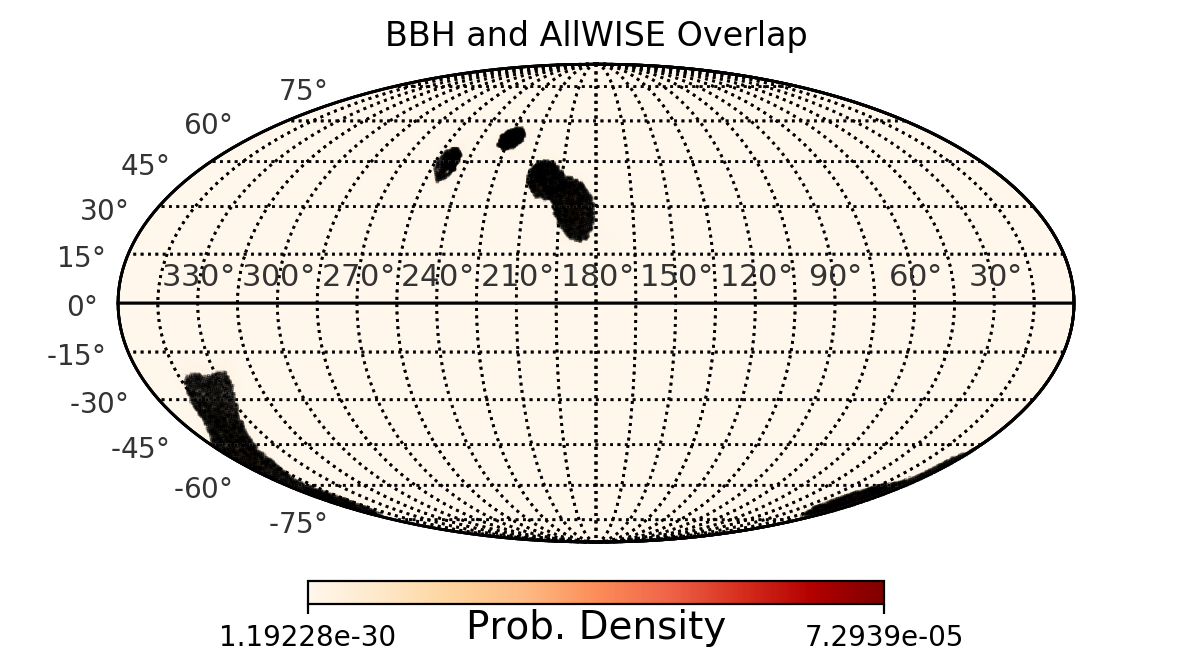

In [54]:
plot_mollview(bbh_data['PROB'], nest=True, cmap='OrRd', title='BBH and AllWISE Overlap', unit='Prob. Density')
hp.projscatter(area_matches['RAJ2000'], area_matches['DEJ2000'], marker='.', s=0.01, c='k', lonlat=True, alpha=0.5)
hp.graticule(15)
plt.savefig('../plots/bbh_agn_overlap.pdf', overwrite=True)

## General Resources:

1. [HEALPy Documentation](https://healpy.readthedocs.io/en/latest/)
2. [GraceDB](https://gracedb.ligo.org/superevents/public/O3/)
3. [GWOSC](https://www.gw-openscience.org/about/)
4. [Fermi GCN Notices](https://gcn.gsfc.nasa.gov/fermi_gbm_subthresh_archive.html)
5. [Anaconda Documentation](https://docs.anaconda.com/anaconda/)
6. [Conda Documentation](https://docs.conda.io/projects/conda/en/latest/index.html)
7. [Conda Forge](https://conda-forge.org/docs/user/introduction.html)
8. [Finding highest prob](https://emfollow.docs.ligo.org/userguide/tutorial/multiorder_skymaps.html)
9. [Install ligo-py37 Environment](https://docs.ligo.org/lscsoft/conda/environments/environment-py37.html)
10. [AllWISE AGN Catalog](https://heasarc.gsfc.nasa.gov/W3Browse/all/allwiseagn.html)
11. [GW170817 Data Release](https://dcc.ligo.org/LIGO-G1701985/public)
12. [LIGO moc Documentation](https://lscsoft.docs.ligo.org/ligo.skymap/moc/index.html)
13. 



```
conda activate
conda config --add channels conda-forge
wget -q https://git.ligo.org/lscsoft/conda/raw/master/environment-py37.yml
conda env create -f environment-py37.yml
```

Reference Stef's code.
Deadline: 07/27** - 08/03



- BNS + Neutrino
- BBH + AGN from allwise (download latest skymap)
- Redo with multiorder files
- Hop tutorial

separate notebook for bbh agn code.

mention rasterize.
